**Last Updated**: *5 May 2025*

**Testing 2D CNN**

In [ ]:
# === Modules ===
import numpy as np
from osgeo import gdal
import pandas as pd
import torch
import torch.nn as nn # nn models
import torch.nn.functional as F # activation functions (incl. ReLu)
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import optuna
from skimage.segmentation import flood
import time
from tqdm import tqdm

In [2]:
# === Functions ===
def load_data(file_path):
    """
    Input: DEM (raster) file path 
    Output: DEM (array) and geotransform information
    """
    try:
        gdal.UseExceptions()
        data = gdal.Open(file_path)
        if data is None:
            raise FileNotFoundError(f"Could not open file: {file_path}")
        data_array = data.ReadAsArray()
        geotransform = data.GetGeoTransform()
        return data_array, geotransform
    except Exception as e:
        raise RuntimeError(f"Error loading DEM: {e}")

def normalize_data(data):
    """
    Input: DEM (array)
    Output: Normalized DEM (array)
    """
    return (data - np.min(data)) / (np.max(data) - np.min(data))    # 0-1 range

def extract_indices(depression_df, geotransform):
    """
    Input: Depressions (dataframe) and geotransform information
    Output: Depressions (dataframe) with location in pixel indices
    """

    # Extract geotransform parameters
    x_origin = geotransform[0]
    y_origin = geotransform[3]
    pixel_width = geotransform[1]
    pixel_height = geotransform[5]

    # Convert to raster pixel indices
    depression_df["col"] = ((depression_df["longitude"] - x_origin) / pixel_width).astype(int)
    depression_df["row"] = ((depression_df["latitude"] - y_origin) / pixel_height).astype(int)

    return depression_df

class CNN(nn.Module):
    def __init__(self, trial, in_channels=4, num_classes=1):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
       
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Global average pooling layer
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc1 = nn.Linear(256*1*1, 128)
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, num_classes)

        # Dropout layers
        self.dropout = nn.Dropout(trial.suggest_float("dropout", 0.4, 0.5)) # > 0.4 for robustness

    def forward(self, x):
        # Convolutional layers with ReLU activation & batch normalization 
        # & Max pooling layers
        x = F.relu(self.bn1(self.conv1(x)))         # (batch, 32, 50, 50)
        x = F.relu(self.bn2(self.conv2(x)))         # (batch, 64, 50, 50)
        x = self.pool(x)                            # (batch, 64, 25, 25)
        
        x = F.relu(self.bn3(self.conv3(x)))         # (batch, 128, 25, 25)
        x = F.relu(self.bn4(self.conv4(x)))         # (batch, 256, 25, 25)
        x = self.pool(x)                            # (batch, 256, 12, 12)

        # Average pooling layer
        x = self.global_pool(x)                     # (batch, 256, 1, 1)
        
        # Flatten
        x = torch.flatten(x, 1)                     # (batch, 256)

        # Fully connected layers with ReLU activation 
        # & Dropout layers
        x = self.dropout(F.relu(self.fc1(x)))      # (batch, 128)
        x = self.dropout(F.relu(self.fc2(x)))      # (batch, 64)
        x = self.output(x)                         # (batch, 1)

        return x

In [3]:
# === Load best model ===
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device will run on {device}")

study = optuna.load_study(study_name="2d-cnn", storage="sqlite:///cd-study.db")
best_trial = study.best_trial
threshold = best_trial.params["threshold"]
model_path = best_trial.user_attrs["model_path"]

model = CNN(trial=best_trial).to(device)
model.load_state_dict(torch.load(model_path))

Device will run on cuda


<All keys matched successfully>

In [4]:
# === Load data ===
dem_path = 'Data/tifs/test_DHMVIIDTMRAS1m_k32.tif'
slope_path = 'Data/tifs/test_slope1m_k32.tif'
curvature_path = 'Data/tifs/test_profile_curvature1m_k32.tif'

dem_array, dem_transform = load_data(dem_path)
dem_array = normalize_data(dem_array)
slope_array, _ = load_data(slope_path)
slope_array = normalize_data(slope_array)
curvature_array, _ = load_data(curvature_path)
curvature_array = normalize_data(curvature_array)

local_min_path = "Data/test_local_minima_with_labels2.csv"
local_min_df = pd.read_csv(local_min_path, dtype={4: str, 5: str})
local_min_df = extract_indices(local_min_df, dem_transform)

In [22]:
# === Run model ===
window_size = 50
half_window = window_size // 2
all_preds = []
all_probs = []
all_inputs = []
all_targets = []

model.eval()

start_time = time.time()
with torch.no_grad():
    for idx, row in tqdm(local_min_df.iterrows(), total=len(local_min_df), desc="Processing Rows", unit="row"):
        row_idx, col_idx = row["row"], row["col"]
        row_min, row_max = max(row_idx - half_window, 0), min(row_idx + half_window, dem_array.shape[0])
        col_min, col_max = max(col_idx - half_window, 0), min(col_idx + half_window, dem_array.shape[1])

        window_dem = dem_array[row_min:row_max, col_min:col_max]
        window_slope = slope_array[row_min:row_max, col_min:col_max]
        window_curvature = curvature_array[row_min:row_max, col_min:col_max]

        seed_row, seed_col = row_idx - row_min, col_idx - col_min
        if (0 <= seed_row < window_dem.shape[0]) and (0 <= seed_col < window_dem.shape[1]):
            window_flood = flood(window_dem, (seed_row, seed_col), tolerance=0.005)
        else:
            window_flood = np.zeros_like(window_dem, dtype=np.float32)

        feature_stack = np.stack([
            window_dem,
            window_slope,
            window_curvature,
            window_flood
        ])

        input_tensor = torch.from_numpy(feature_stack).unsqueeze(0).float().to(device)

        output = model(input_tensor).squeeze(0)
        prob = torch.sigmoid(output).item()
        pred = int(prob >= threshold)

        all_probs.append(prob)
        all_preds.append(pred)
        all_inputs.append(feature_stack[0])
        all_targets.append(row["label"])
        
local_min_df["prob"] = all_probs
local_min_df["pred"] = all_preds
elapsed_time = time.time() - start_time

updated_local_min_path = "Data/updated_test_local_minima_with_labels.csv"
local_min_df.to_csv(updated_local_min_path, index=False)
print(f"Updated CSV saved to {updated_local_min_path}")
print(f"Time taken: {elapsed_time:.2f} seconds")

Processing Rows: 100%|██████████| 31091/31091 [01:55<00:00, 269.48row/s]


Updated CSV saved to Data/updated_test_local_minima_with_labels.csv
Time taken: 115.40 seconds


Testing Results:
Accuracy     : 0.9744
Precision    : 0.0438
Recall       : 0.5147
F1 Score     : 0.0807
PR AUC       : 0.0731


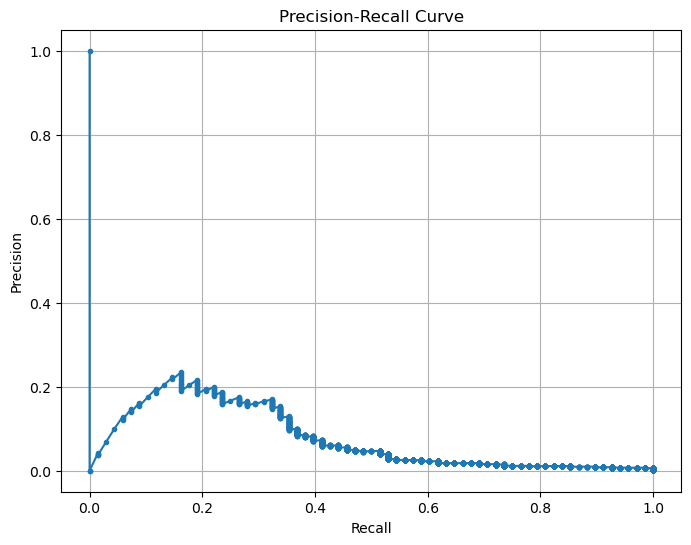

In [23]:
# === Metrics ===
all_targets = local_min_df["label"].values
all_preds = local_min_df["pred"].values
all_probs = local_min_df["prob"].values

f1 = f1_score(all_targets, all_preds, zero_division=0)
precision = precision_score(all_targets, all_preds, zero_division=0)
recall = recall_score(all_targets, all_preds, zero_division=0)
precision_curve, recall_curve, _ = precision_recall_curve(all_targets, all_probs)
pr_auc = auc(recall_curve, precision_curve)

val_corr = sum([p == t for p, t in zip(all_preds, all_targets)])
val_accuracy = val_corr / len(all_targets)

# Print nicely
print(f"Testing Results:")
print(f"Accuracy     : {val_accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"PR AUC       : {pr_auc:.4f}")

# Plot PR curve
plt.figure(figsize=(8,6))
plt.plot(recall_curve, precision_curve, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

In [24]:
# === Functions: Visualize predictions ===
def visualize_predictions(inputs, targets, preds, max_per_group=5):
    tp, fp, fn = [], [], []

    for i in range(len(inputs)):
        input_img = inputs[i]
        true = targets[i].item()
        pred = preds[i].item()

        if true == 1 and pred == 1:
            tp.append(input_img)
        elif true == 0 and pred == 1:
            fp.append(input_img)
        elif true == 1 and pred == 0:
            fn.append(input_img)

    def plot_group(imgs, title, n=max_per_group):
        n = min(len(imgs), n)
        fig, axs = plt.subplots(1, n, figsize=(n * 2, 2))
        fig.suptitle(title)
        for i in range(n):
            img = imgs[i]
            axs[i].imshow(img, cmap='terrain')
            axs[i].axis('off')
        plt.tight_layout()
        plt.show()

    plot_group(tp, "True Positives")
    plot_group(fp, "False Positives")
    plot_group(fn, "False Negatives")

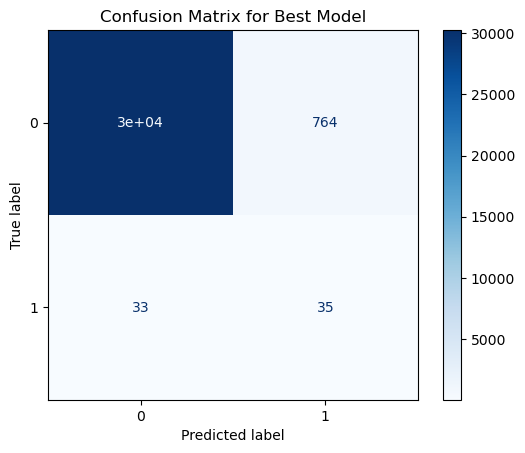

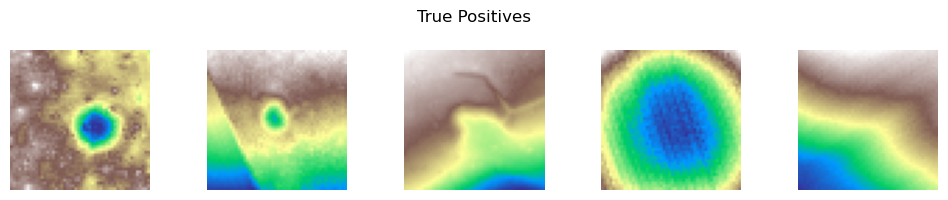

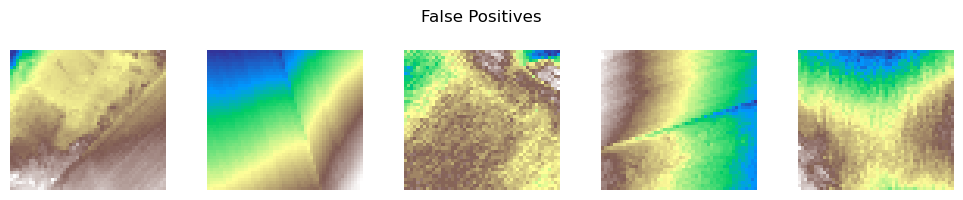

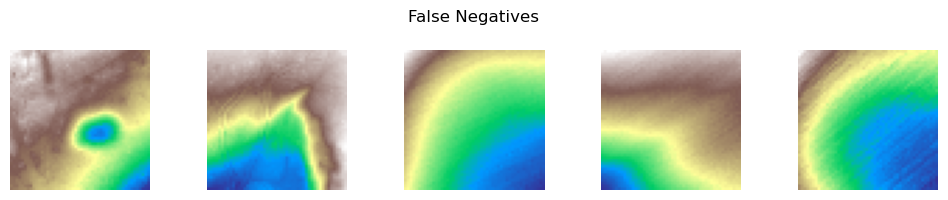

In [25]:
# === Plot confusion matrix ===
cm = confusion_matrix(all_targets, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Best Model")
plt.show()

# Visualize predictions
visualize_predictions(
    inputs=[torch.tensor(i) for i in all_inputs],
    targets=torch.tensor(all_targets),
    preds=torch.tensor(all_preds)
)